In [30]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/kaggle/working/6D_pose"   #Modify here for kaggle
branch = "pose_Pointnet"

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    # %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)


/kaggle/working/6D_pose
Already on 'pose_Pointnet'
Your branch is up to date with 'origin/pose_Pointnet'.
HEAD is now at 69de04a Feat: added RGB eval and fix issues
Updated https://github.com/fraco03/6D_pose.git to /kaggle/working/6D_pose


In [2]:
sys.path.insert(0,"/kaggle/working/6D_pose")

In [ ]:
# AVOID RUNNING IN KAGGLE!

%cd ..
!gdown --fuzzy https://drive.google.com/file/d/1zNthSyiBdPUfn7BmUKPbKoGgQdG1vGnS/view?usp=drive_link -O Linemod_preprocessed.zip
!unzip Linemod_preprocessed.zip
%cd 6D_pose

In [3]:
from google.colab import drive
from utils.load_data import mount_drive

# Mounting part
mount_drive()

NotImplementedError: Mounting drive is unsupported in this environment. Use PyDrive2 instead. See examples at https://colab.research.google.com/notebooks/io.ipynb#scrollTo=7taylj9wpsA2.

In [ ]:
%mv Linemod_preprocessed working/

In [31]:
# dataset_root = "/content/drive/MyDrive/Linemod_preprocessed" #Modify here for kaggle
# dataset_root = "../../Linemod_preprocessed_small"
# dataset_root = "/content/Linemod_preprocessed"
# dataset_root = "/kaggle/working/Linemod_preprocessed"
dataset_root = "/kaggle/input/line-mode/Linemod_preprocessed"

print("\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")



✅ Setup complete!
📁 Dataset path: /kaggle/input/line-mode/Linemod_preprocessed


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%mv Linemod_preprocessed ./working

In [32]:
!pip install plyfile

In [33]:
import sys

sys.path.append('../..')

In [ ]:
from src.pose_pointnet.dataset import PointNetLineModDataset

train_dataset = PointNetLineModDataset(
    root_dir=dataset_root,
    split="train",
    augment=True
)

test_dataset = PointNetLineModDataset(
    root_dir=dataset_root,
    split="test",
    augment=False
)


✅ Loaded PointNetLineModDataset
   Split: train (Ratio: 0.8)
   Num Points: 1024
   Total samples: 12634
✅ Loaded PointNetLineModDataset
   Split: test (Ratio: 0.8)
   Num Points: 1024
   Total samples: 3166


In [36]:
import torch
sample = train_dataset[0]

print(f"Sample keys: {sample.keys()}")
for key, value in sample.items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: Tensor of shape {value.shape} and dtype {value.dtype}")
    else:
        print(f"  {key}: {type(value)} with value {value}")

Sample keys: dict_keys(['points', 'centroid', 'rotation', 't_residual', 'gt_translation', 'object_id', 'class_idx', 'img_id', 'cam_K'])
  points: Tensor of shape torch.Size([3, 1024]) and dtype torch.float32
  centroid: Tensor of shape torch.Size([3]) and dtype torch.float32
  rotation: Tensor of shape torch.Size([4]) and dtype torch.float32
  t_residual: Tensor of shape torch.Size([3]) and dtype torch.float32
  gt_translation: Tensor of shape torch.Size([3]) and dtype torch.float32
  object_id: <class 'int'> with value 1
  class_idx: <class 'str'> with value ape
  img_id: <class 'int'> with value 987
  cam_K: Tensor of shape torch.Size([3, 3]) and dtype torch.float32


In [37]:
import torch

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [38]:
from utils.linemod_config import get_linemod_config
import numpy as np
import torch


linemod_config = get_linemod_config(dataset_root)

all_model_points = []
NUM_POINTS = 1000  # Number of points to sample from each model
VALID_OBJ_IDS = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15] 
for obj_id in VALID_OBJ_IDS:
    model_points = linemod_config.get_model_3d(obj_id, unit='m')  # (N, 3)
    if model_points.shape[0] >= NUM_POINTS:
        choice = np.random.choice(model_points.shape[0], NUM_POINTS, replace=False)
    else:
        choice = np.random.choice(model_points.shape[0], NUM_POINTS, replace=True)
    model_points = model_points[choice, :]
    all_model_points.append(torch.tensor(model_points, dtype=torch.float32))
all_model_points = torch.stack(all_model_points, dim=0)  # (Num_Classes, NUM_POINTS, 3)
all_model_points = all_model_points.to(device)

max_obj_id = max(VALID_OBJ_IDS)

# Create a lookup table: obj_id -> index
obj_id_to_idx = torch.full((max_obj_id + 1,), -1, dtype=torch.long, device=device)
for idx, obj_id in enumerate(VALID_OBJ_IDS):
    obj_id_to_idx[obj_id] = idx


In [39]:
all_model_points.shape

torch.Size([13, 1000, 3])

In [40]:
from src.pose_pointnet.loss import MultiObjectPointMatchingLoss
import torch.nn as nn
from src.pose_pointnet.model import PointNetPoseModel
from torch.optim import Adam, AdamW

model = PointNetPoseModel()

if torch.cuda.device_count() > 1:
    print(f"🔥 Using {torch.cuda.device_count()} GPU!")
    model = nn.DataParallel(model)

model = model.to(device)

# Loss function and optimizer
criterion = MultiObjectPointMatchingLoss(all_model_points)
optimizer = AdamW(
    model.parameters(), 
    lr=0.001, 
    betas=(0.9, 0.999), 
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=100,      # Imposta il numero delle tue epoche totali qui!
    eta_min=1e-5
)

🔥 Using 2 GPU!


In [41]:
def set_bn_momentum_default(curr_epoch, total_epochs, model):
    """
    Decade il momentum della Batch Norm da 0.1 a 0.01 seguendo una curva a step o coseno.
    In PyTorch il default momentum è 0.1.
    """
    # Formula originale PointNet: decade del 50% ogni tot step
    # Qui usiamo una versione coseno più moderna e fluida
    
    # Calcola il momentum target: parte da 0.1 e scende a 0.01
    start_mom = 0.1
    end_mom = 0.01
    
    # Interpolazione semplice basata sull'epoca
    momentum = end_mom + (start_mom - end_mom) * (1 - (curr_epoch / total_epochs))
    
    # Applica a tutti i layer di Batch Norm nel modello
    for m in model.modules():
        if isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
            m.momentum = momentum

In [42]:
from torch.utils.data import DataLoader

batch_size = 128  #double GPU

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True,
                          persistent_workers=True,
                          drop_last=True)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         pin_memory=True,
                         persistent_workers=True,
                         num_workers=4)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DecoupledPoseLoss(nn.Module):
    def __init__(self, rot_weight=1.0, trans_weight=1.0):
        super().__init__()
        self.rot_weight = rot_weight
        self.trans_weight = trans_weight
        # Log per vedere i valori separati
        self.last_rot_loss = 0.0
        self.last_trans_loss = 0.0

    def forward(self, pred_q, pred_t, gt_q, gt_t):
        """
        pred_t e gt_t devono essere entrambi assoluti (o entrambi residui).
        """
        
        # --- 1. LOSS TRASLAZIONE (MSE o L1) ---
        # MSE è più aggressivo sugli errori grandi, L1 è più stabile
        loss_trans = F.mse_loss(pred_t, gt_t)
        
        # --- 2. LOSS ROTAZIONE (Cosine Distance) ---
        # I quaternioni q e -q rappresentano la stessa rotazione.
        # Quindi vogliamo massimizzare il valore assoluto del prodotto scalare.
        # Loss = 1 - |<q1, q2>|
        dot_product = torch.sum(pred_q * gt_q, dim=1)
        loss_rot = 1.0 - torch.mean(torch.abs(dot_product))
        
        # --- 3. SOMMA PESATA ---
        total_loss = (self.trans_weight * loss_trans) + (self.rot_weight * loss_rot)
        
        # Salviamo i valori per stamparli (opzionale)
        self.last_trans_loss = loss_trans.item()
        self.last_rot_loss = loss_rot.item()
        
        return total_loss

In [19]:
def compute_rotation_error(pred_q, gt_q):
    """
    Calcola l'errore angolare medio in GRADI tra due batch di quaternioni.
    """
    # Prodotto scalare tra i quaternioni (q1 * q2)
    # clamp serve per evitare errori numerici se il valore supera 1.0 per pochissimo
    dot_product = torch.sum(pred_q * gt_q, dim=1)
    dot_product = torch.clamp(torch.abs(dot_product), max=1.0) 
    
    # Formula: 2 * arccos(|dot|)
    theta_rad = 2 * torch.acos(dot_product)
    theta_deg = torch.rad2deg(theta_rad)
    
    return theta_deg.mean().item()

In [43]:
from tqdm import tqdm
import os
import torch
from datetime import datetime

# ==========================================
# 0. SETUP AND CONFIGURATION
# ==========================================
num_epochs = 100  # PointNet converges relatively fast
best_test_loss = float('inf')
batch_size = 32  # Adjust based on your GPU VRAM

# Setup checkpoint directory
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint_dir = f'/kaggle/working/POINTNET_{timestamp}'
# checkpoint_dir = f'./POINTNET_{timestamp}'
os.makedirs(checkpoint_dir, exist_ok=True)

# Trackers for plotting
train_losses = []
test_losses = []

print(f"🚀 Starting PointNet Training on {device}")
print(f"📁 Checkpoints will be saved to: {checkpoint_dir}")
print(f"🗺️  Object ID Mapping created for {len(obj_id_to_idx)} objects.")

# ==========================================
# 1. TRAINING LOOP
# ==========================================
for epoch in range(num_epochs):
    set_bn_momentum_default(epoch, num_epochs, model)
    
    model.train()
    epoch_loss = 0.0

    # Initialize progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")
    
    for batch in train_pbar:
        # Move data to GPU
        # PointNet input: (Batch, 3, Num_Points)
        points = batch['points'].to(device)  
        
        # Auxiliary data for reconstruction and loss
        centroids = batch['centroid'].to(device)       # (B, 3)
        gt_rotations = batch['rotation'].to(device)    # (B, 4)
        gt_t_absolute = batch['gt_translation'].to(device) # (B, 3) - Absolute target
        
        # Handle Object IDs for Loss Indexing
        raw_obj_ids = batch['object_id'].tolist()
        # Map raw IDs (e.g., 15) to buffer indices (e.g., 12)
        target_indices = torch.tensor(
            [obj_id_to_idx[oid] for oid in raw_obj_ids], 
            dtype=torch.long, device=device
        )

        # --- FORWARD PASS ---
        optimizer.zero_grad()
        
        # The network predicts: 
        # 1. Quaternion (pred_q)
        # 2. Residual Translation relative to centroid (pred_t_res)
        pred_q, pred_t_res = model(points)

        # --- RECONSTRUCTION ---
        # Reconstruct absolute translation for the ADD Loss
        # Absolute_Pos = Centroid + Residual
        pred_t_abs = centroids + pred_t_res

        # --- LOSS CALCULATION ---
        # Using MultiObjectPointMatchingLoss (ADD metric)
        loss_add = criterion(
            pred_q=pred_q, 
            pred_t=pred_t_abs,   # Pass the reconstructed absolute translation
            gt_q=gt_rotations, 
            gt_t=gt_t_absolute, 
            class_indices=target_indices
        )

        # pure loss on quaternions
        # dot = torch.sum(pred_q * gt_rotations, dim=1)
        # loss_rot_pure = 1.0 - torch.mean(torch.abs(dot))
        
        # Final Hybrid Loss
        loss = loss_add # + (2.0 * loss_rot_pure)
        
        loss.backward()
        optimizer.step()

        # Update stats
        epoch_loss += loss.item()
        train_pbar.set_postfix({'ADD Loss (m)': f"{loss.item():.4f}"})

    # Calculate average training loss
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    scheduler.step()

    # ==========================================
    # 2. VALIDATION LOOP
    # ==========================================
    model.eval()
    test_loss = 0.0
    val_pbar = tqdm(test_loader, desc="Validating")
    
    with torch.no_grad():
        for batch in val_pbar:
            # Move data to GPU
            points = batch['points'].to(device)
            centroids = batch['centroid'].to(device)
            gt_rotations = batch['rotation'].to(device)
            gt_t_absolute = batch['gt_translation'].to(device)
            
            # Map IDs
            raw_obj_ids = batch['object_id'].tolist()
            target_indices = torch.tensor(
                [obj_id_to_idx[oid] for oid in raw_obj_ids], 
                dtype=torch.long, device=device
            )

            # Forward
            pred_q, pred_t_res = model(points)

            # Reconstruction
            pred_t_abs = centroids + pred_t_res

            # Loss
            loss = criterion(
                pred_q=pred_q, 
                pred_t=pred_t_abs, 
                gt_q=gt_rotations, 
                gt_t=gt_t_absolute, 
                class_indices=target_indices
            )

            rot_err = compute_rotation_error(pred_q, gt_rotations)
            val_pbar.set_postfix({
                'Val Loss': f"{loss.item():.4f}", 
                'Rot Err (deg)': f"{rot_err:.1f}°"  # <--- ECCOLO!
            })
            
            test_loss += loss.item()
            val_pbar.set_postfix({'Val Loss': f"{loss.item():.4f}"})

    # Calculate average validation loss
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f"📊 Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} m | Val Loss: {avg_test_loss:.4f} m")

    # ==========================================
    # 3. CHECKPOINT SAVING
    # ==========================================
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
        
        # Handle DataParallel state_dict if necessary
        model_state = model.module.state_dict() if isinstance(model, torch.nn.DataParallel) else model.state_dict()
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_test_loss,
            'config': { 
                'num_points': 1024, # Useful for inference
                'obj_map': obj_id_to_idx
            }
        }, checkpoint_path)
        print(f"✅ New Record! Model saved with Loss: {best_test_loss:.4f} m")
    else:
        print(f"⏳ No improvement (Best: {best_test_loss:.4f} m)")
    
    print("-" * 60)

🚀 Starting PointNet Training on cuda
📁 Checkpoints will be saved to: /kaggle/working/POINTNET_20251222_133052
🗺️  Object ID Mapping created for 16 objects.


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s, Val Loss=0.0724]                     


📊 Epoch [1/100] | Train Loss: 0.2294 m | Val Loss: 0.0686 m
✅ New Record! Model saved with Loss: 0.0686 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, Val Loss=0.0631]                     


📊 Epoch [2/100] | Train Loss: 0.1056 m | Val Loss: 0.0566 m
✅ New Record! Model saved with Loss: 0.0566 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s, Val Loss=0.0630]                     


📊 Epoch [3/100] | Train Loss: 0.0720 m | Val Loss: 0.0507 m
✅ New Record! Model saved with Loss: 0.0507 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.53it/s, Val Loss=0.0536]                     


📊 Epoch [4/100] | Train Loss: 0.0575 m | Val Loss: 0.0496 m
✅ New Record! Model saved with Loss: 0.0496 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.84it/s, Val Loss=0.0446]                     


📊 Epoch [5/100] | Train Loss: 0.0493 m | Val Loss: 0.0441 m
✅ New Record! Model saved with Loss: 0.0441 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s, Val Loss=0.0393]                      


📊 Epoch [6/100] | Train Loss: 0.0459 m | Val Loss: 0.0426 m
✅ New Record! Model saved with Loss: 0.0426 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.88it/s, Val Loss=0.0347]                     


📊 Epoch [7/100] | Train Loss: 0.0404 m | Val Loss: 0.0401 m
✅ New Record! Model saved with Loss: 0.0401 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s, Val Loss=0.0327]                      


📊 Epoch [8/100] | Train Loss: 0.0392 m | Val Loss: 0.0386 m
✅ New Record! Model saved with Loss: 0.0386 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s, Val Loss=0.0327]                     


📊 Epoch [9/100] | Train Loss: 0.0371 m | Val Loss: 0.0408 m
⏳ No improvement (Best: 0.0386 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s, Val Loss=0.0374]                      


📊 Epoch [10/100] | Train Loss: 0.0358 m | Val Loss: 0.0361 m
✅ New Record! Model saved with Loss: 0.0361 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s, Val Loss=0.0332]                      


📊 Epoch [11/100] | Train Loss: 0.0349 m | Val Loss: 0.0347 m
✅ New Record! Model saved with Loss: 0.0347 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s, Val Loss=0.0334]                      


📊 Epoch [12/100] | Train Loss: 0.0331 m | Val Loss: 0.0346 m
✅ New Record! Model saved with Loss: 0.0346 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s, Val Loss=0.0348]                      


📊 Epoch [13/100] | Train Loss: 0.0321 m | Val Loss: 0.0346 m
⏳ No improvement (Best: 0.0346 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Val Loss=0.0254]                      


📊 Epoch [14/100] | Train Loss: 0.0311 m | Val Loss: 0.0305 m
✅ New Record! Model saved with Loss: 0.0305 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s, Val Loss=0.0258]                     


📊 Epoch [15/100] | Train Loss: 0.0296 m | Val Loss: 0.0313 m
⏳ No improvement (Best: 0.0305 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Val Loss=0.0256]                      


📊 Epoch [16/100] | Train Loss: 0.0296 m | Val Loss: 0.0295 m
✅ New Record! Model saved with Loss: 0.0295 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.87it/s, Val Loss=0.0260]                     


📊 Epoch [17/100] | Train Loss: 0.0279 m | Val Loss: 0.0287 m
✅ New Record! Model saved with Loss: 0.0287 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, Val Loss=0.0291]                     


📊 Epoch [18/100] | Train Loss: 0.0270 m | Val Loss: 0.0311 m
⏳ No improvement (Best: 0.0287 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.93it/s, Val Loss=0.0386]                      


📊 Epoch [19/100] | Train Loss: 0.0264 m | Val Loss: 0.0339 m
⏳ No improvement (Best: 0.0287 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.86it/s, Val Loss=0.0317]                      


📊 Epoch [20/100] | Train Loss: 0.0262 m | Val Loss: 0.0341 m
⏳ No improvement (Best: 0.0287 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.92it/s, Val Loss=0.0283]                     


📊 Epoch [21/100] | Train Loss: 0.0264 m | Val Loss: 0.0311 m
⏳ No improvement (Best: 0.0287 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s, Val Loss=0.0250]                     


📊 Epoch [22/100] | Train Loss: 0.0258 m | Val Loss: 0.0263 m
✅ New Record! Model saved with Loss: 0.0263 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.88it/s, Val Loss=0.0243]                     


📊 Epoch [23/100] | Train Loss: 0.0251 m | Val Loss: 0.0248 m
✅ New Record! Model saved with Loss: 0.0248 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s, Val Loss=0.0300]                     


📊 Epoch [24/100] | Train Loss: 0.0242 m | Val Loss: 0.0251 m
⏳ No improvement (Best: 0.0248 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.87it/s, Val Loss=0.0297]                     


📊 Epoch [25/100] | Train Loss: 0.0232 m | Val Loss: 0.0288 m
⏳ No improvement (Best: 0.0248 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.88it/s, Val Loss=0.0228]                     


📊 Epoch [26/100] | Train Loss: 0.0224 m | Val Loss: 0.0237 m
✅ New Record! Model saved with Loss: 0.0237 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.80it/s, Val Loss=0.0255]                     


📊 Epoch [27/100] | Train Loss: 0.0222 m | Val Loss: 0.0249 m
⏳ No improvement (Best: 0.0237 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.94it/s, Val Loss=0.0294]                     


📊 Epoch [28/100] | Train Loss: 0.0220 m | Val Loss: 0.0325 m
⏳ No improvement (Best: 0.0237 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.80it/s, Val Loss=0.0201]                     


📊 Epoch [29/100] | Train Loss: 0.0220 m | Val Loss: 0.0248 m
⏳ No improvement (Best: 0.0237 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.94it/s, Val Loss=0.0242]                     


📊 Epoch [30/100] | Train Loss: 0.0220 m | Val Loss: 0.0249 m
⏳ No improvement (Best: 0.0237 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.87it/s, Val Loss=0.0324]                     


📊 Epoch [31/100] | Train Loss: 0.0211 m | Val Loss: 0.0288 m
⏳ No improvement (Best: 0.0237 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.90it/s, Val Loss=0.0300]                     


📊 Epoch [32/100] | Train Loss: 0.0210 m | Val Loss: 0.0264 m
⏳ No improvement (Best: 0.0237 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s, Val Loss=0.0213]                     


📊 Epoch [33/100] | Train Loss: 0.0204 m | Val Loss: 0.0224 m
✅ New Record! Model saved with Loss: 0.0224 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.86it/s, Val Loss=0.0273]                     


📊 Epoch [34/100] | Train Loss: 0.0199 m | Val Loss: 0.0247 m
⏳ No improvement (Best: 0.0224 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.94it/s, Val Loss=0.0204]                     


📊 Epoch [35/100] | Train Loss: 0.0191 m | Val Loss: 0.0233 m
⏳ No improvement (Best: 0.0224 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.94it/s, Val Loss=0.0215]                     


📊 Epoch [36/100] | Train Loss: 0.0195 m | Val Loss: 0.0200 m
✅ New Record! Model saved with Loss: 0.0200 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.96it/s, Val Loss=0.0327]                     


📊 Epoch [37/100] | Train Loss: 0.0186 m | Val Loss: 0.0283 m
⏳ No improvement (Best: 0.0200 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.80it/s, Val Loss=0.0220]                     


📊 Epoch [38/100] | Train Loss: 0.0185 m | Val Loss: 0.0197 m
✅ New Record! Model saved with Loss: 0.0197 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.99it/s, Val Loss=0.0207]                     


📊 Epoch [39/100] | Train Loss: 0.0181 m | Val Loss: 0.0196 m
✅ New Record! Model saved with Loss: 0.0196 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.86it/s, Val Loss=0.0241]                     


📊 Epoch [40/100] | Train Loss: 0.0172 m | Val Loss: 0.0202 m
⏳ No improvement (Best: 0.0196 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s, Val Loss=0.0252]                      


📊 Epoch [41/100] | Train Loss: 0.0175 m | Val Loss: 0.0253 m
⏳ No improvement (Best: 0.0196 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.86it/s, Val Loss=0.0203]                     


📊 Epoch [42/100] | Train Loss: 0.0175 m | Val Loss: 0.0182 m
✅ New Record! Model saved with Loss: 0.0182 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.94it/s, Val Loss=0.0307]                     


📊 Epoch [43/100] | Train Loss: 0.0169 m | Val Loss: 0.0240 m
⏳ No improvement (Best: 0.0182 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s, Val Loss=0.0187]                     


📊 Epoch [44/100] | Train Loss: 0.0171 m | Val Loss: 0.0181 m
✅ New Record! Model saved with Loss: 0.0181 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.89it/s, Val Loss=0.0259]                     


📊 Epoch [45/100] | Train Loss: 0.0168 m | Val Loss: 0.0242 m
⏳ No improvement (Best: 0.0181 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.93it/s, Val Loss=0.0276]                     


📊 Epoch [46/100] | Train Loss: 0.0174 m | Val Loss: 0.0246 m
⏳ No improvement (Best: 0.0181 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.92it/s, Val Loss=0.0168]                     


📊 Epoch [47/100] | Train Loss: 0.0165 m | Val Loss: 0.0161 m
✅ New Record! Model saved with Loss: 0.0161 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.86it/s, Val Loss=0.0230]                     


📊 Epoch [48/100] | Train Loss: 0.0158 m | Val Loss: 0.0232 m
⏳ No improvement (Best: 0.0161 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.88it/s, Val Loss=0.0158]                     


📊 Epoch [49/100] | Train Loss: 0.0157 m | Val Loss: 0.0165 m
⏳ No improvement (Best: 0.0161 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.93it/s, Val Loss=0.0186]                     


📊 Epoch [50/100] | Train Loss: 0.0164 m | Val Loss: 0.0188 m
⏳ No improvement (Best: 0.0161 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.90it/s, Val Loss=0.0183]                     


📊 Epoch [51/100] | Train Loss: 0.0150 m | Val Loss: 0.0191 m
⏳ No improvement (Best: 0.0161 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.90it/s, Val Loss=0.0218]                     


📊 Epoch [52/100] | Train Loss: 0.0155 m | Val Loss: 0.0175 m
⏳ No improvement (Best: 0.0161 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.84it/s, Val Loss=0.0148]                     


📊 Epoch [53/100] | Train Loss: 0.0151 m | Val Loss: 0.0155 m
✅ New Record! Model saved with Loss: 0.0155 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.80it/s, Val Loss=0.0229]                     


📊 Epoch [54/100] | Train Loss: 0.0144 m | Val Loss: 0.0202 m
⏳ No improvement (Best: 0.0155 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.71it/s, Val Loss=0.0196]                     


📊 Epoch [55/100] | Train Loss: 0.0148 m | Val Loss: 0.0168 m
⏳ No improvement (Best: 0.0155 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.94it/s, Val Loss=0.0166]                     


📊 Epoch [56/100] | Train Loss: 0.0139 m | Val Loss: 0.0150 m
✅ New Record! Model saved with Loss: 0.0150 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:04<00:00,  5.02it/s, Val Loss=0.0212]                     


📊 Epoch [57/100] | Train Loss: 0.0138 m | Val Loss: 0.0183 m
⏳ No improvement (Best: 0.0150 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:04<00:00,  5.01it/s, Val Loss=0.0206]                     


📊 Epoch [58/100] | Train Loss: 0.0142 m | Val Loss: 0.0170 m
⏳ No improvement (Best: 0.0150 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.97it/s, Val Loss=0.0161]                     


📊 Epoch [59/100] | Train Loss: 0.0135 m | Val Loss: 0.0140 m
✅ New Record! Model saved with Loss: 0.0140 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s, Val Loss=0.0160]                     


📊 Epoch [60/100] | Train Loss: 0.0132 m | Val Loss: 0.0140 m
✅ New Record! Model saved with Loss: 0.0140 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.84it/s, Val Loss=0.0183]                     


📊 Epoch [61/100] | Train Loss: 0.0135 m | Val Loss: 0.0164 m
⏳ No improvement (Best: 0.0140 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s, Val Loss=0.0162]                     


📊 Epoch [62/100] | Train Loss: 0.0131 m | Val Loss: 0.0139 m
✅ New Record! Model saved with Loss: 0.0139 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.87it/s, Val Loss=0.0162]                     


📊 Epoch [63/100] | Train Loss: 0.0130 m | Val Loss: 0.0141 m
⏳ No improvement (Best: 0.0139 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.93it/s, Val Loss=0.0152]                     


📊 Epoch [64/100] | Train Loss: 0.0128 m | Val Loss: 0.0132 m
✅ New Record! Model saved with Loss: 0.0132 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.84it/s, Val Loss=0.0145]                     


📊 Epoch [65/100] | Train Loss: 0.0130 m | Val Loss: 0.0131 m
✅ New Record! Model saved with Loss: 0.0131 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s, Val Loss=0.0153]                     


📊 Epoch [66/100] | Train Loss: 0.0126 m | Val Loss: 0.0143 m
⏳ No improvement (Best: 0.0131 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.83it/s, Val Loss=0.0130]                     


📊 Epoch [67/100] | Train Loss: 0.0125 m | Val Loss: 0.0123 m
✅ New Record! Model saved with Loss: 0.0123 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.78it/s, Val Loss=0.0135]                     


📊 Epoch [68/100] | Train Loss: 0.0122 m | Val Loss: 0.0119 m
✅ New Record! Model saved with Loss: 0.0119 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s, Val Loss=0.0149]                     


📊 Epoch [69/100] | Train Loss: 0.0122 m | Val Loss: 0.0121 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.93it/s, Val Loss=0.0153]                     


📊 Epoch [70/100] | Train Loss: 0.0122 m | Val Loss: 0.0129 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.97it/s, Val Loss=0.0170]                     


📊 Epoch [71/100] | Train Loss: 0.0123 m | Val Loss: 0.0158 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.94it/s, Val Loss=0.0146]                     


📊 Epoch [72/100] | Train Loss: 0.0119 m | Val Loss: 0.0130 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.49it/s, Val Loss=0.0140]                     


📊 Epoch [73/100] | Train Loss: 0.0118 m | Val Loss: 0.0123 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.87it/s, Val Loss=0.0132]                     


📊 Epoch [74/100] | Train Loss: 0.0118 m | Val Loss: 0.0122 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Val Loss=0.0116]                     


📊 Epoch [75/100] | Train Loss: 0.0118 m | Val Loss: 0.0114 m
✅ New Record! Model saved with Loss: 0.0114 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s, Val Loss=0.0141]                     


📊 Epoch [76/100] | Train Loss: 0.0115 m | Val Loss: 0.0127 m
⏳ No improvement (Best: 0.0114 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.90it/s, Val Loss=0.0131]                     


📊 Epoch [77/100] | Train Loss: 0.0114 m | Val Loss: 0.0124 m
⏳ No improvement (Best: 0.0114 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.83it/s, Val Loss=0.0131]                     


📊 Epoch [78/100] | Train Loss: 0.0112 m | Val Loss: 0.0118 m
⏳ No improvement (Best: 0.0114 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.84it/s, Val Loss=0.0133]                     


📊 Epoch [79/100] | Train Loss: 0.0112 m | Val Loss: 0.0113 m
✅ New Record! Model saved with Loss: 0.0113 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s, Val Loss=0.0116]                     


📊 Epoch [80/100] | Train Loss: 0.0111 m | Val Loss: 0.0105 m
✅ New Record! Model saved with Loss: 0.0105 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s, Val Loss=0.0128]                     


📊 Epoch [81/100] | Train Loss: 0.0109 m | Val Loss: 0.0116 m
⏳ No improvement (Best: 0.0105 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s, Val Loss=0.0140]                     


📊 Epoch [82/100] | Train Loss: 0.0110 m | Val Loss: 0.0114 m
⏳ No improvement (Best: 0.0105 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, Val Loss=0.0115]                     


📊 Epoch [83/100] | Train Loss: 0.0109 m | Val Loss: 0.0102 m
✅ New Record! Model saved with Loss: 0.0102 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, Val Loss=0.0134]                     


📊 Epoch [84/100] | Train Loss: 0.0109 m | Val Loss: 0.0121 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.51it/s, Val Loss=0.0115]                     


📊 Epoch [85/100] | Train Loss: 0.0108 m | Val Loss: 0.0103 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.80it/s, Val Loss=0.0119]                     


📊 Epoch [86/100] | Train Loss: 0.0107 m | Val Loss: 0.0102 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.88it/s, Val Loss=0.0125]                     


📊 Epoch [87/100] | Train Loss: 0.0107 m | Val Loss: 0.0107 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s, Val Loss=0.0109]                     


📊 Epoch [88/100] | Train Loss: 0.0107 m | Val Loss: 0.0100 m
✅ New Record! Model saved with Loss: 0.0100 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.83it/s, Val Loss=0.0109]                     


📊 Epoch [89/100] | Train Loss: 0.0106 m | Val Loss: 0.0101 m
⏳ No improvement (Best: 0.0100 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.84it/s, Val Loss=0.0122]                     


📊 Epoch [90/100] | Train Loss: 0.0106 m | Val Loss: 0.0106 m
⏳ No improvement (Best: 0.0100 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.84it/s, Val Loss=0.0108]                     


📊 Epoch [91/100] | Train Loss: 0.0104 m | Val Loss: 0.0098 m
✅ New Record! Model saved with Loss: 0.0098 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.78it/s, Val Loss=0.0117]                     


📊 Epoch [92/100] | Train Loss: 0.0104 m | Val Loss: 0.0100 m
⏳ No improvement (Best: 0.0098 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.87it/s, Val Loss=0.0114]                     


📊 Epoch [93/100] | Train Loss: 0.0103 m | Val Loss: 0.0098 m
⏳ No improvement (Best: 0.0098 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s, Val Loss=0.0115]                     


📊 Epoch [94/100] | Train Loss: 0.0105 m | Val Loss: 0.0099 m
⏳ No improvement (Best: 0.0098 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.83it/s, Val Loss=0.0105]                     


📊 Epoch [95/100] | Train Loss: 0.0105 m | Val Loss: 0.0097 m
✅ New Record! Model saved with Loss: 0.0097 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s, Val Loss=0.0107]                     


📊 Epoch [96/100] | Train Loss: 0.0104 m | Val Loss: 0.0095 m
✅ New Record! Model saved with Loss: 0.0095 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Val Loss=0.0111]                     


📊 Epoch [97/100] | Train Loss: 0.0103 m | Val Loss: 0.0096 m
⏳ No improvement (Best: 0.0095 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s, Val Loss=0.0106]                     


📊 Epoch [98/100] | Train Loss: 0.0103 m | Val Loss: 0.0095 m
✅ New Record! Model saved with Loss: 0.0095 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, Val Loss=0.0112]                     


📊 Epoch [99/100] | Train Loss: 0.0102 m | Val Loss: 0.0094 m
✅ New Record! Model saved with Loss: 0.0094 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s, Val Loss=0.0106]                     

📊 Epoch [100/100] | Train Loss: 0.0103 m | Val Loss: 0.0095 m
⏳ No improvement (Best: 0.0094 m)
------------------------------------------------------------


✅ Plot saved: /kaggle/working/POINTNET_20251222_133052/loss_comparison.png


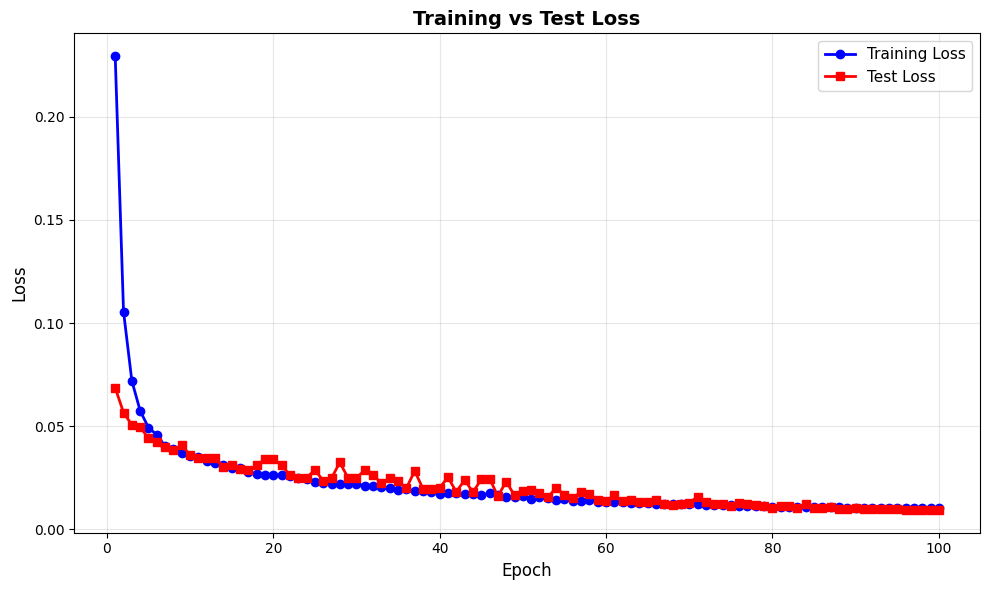

✅ Plot saved: /kaggle/working/POINTNET_20251222_133052/training_loss.png


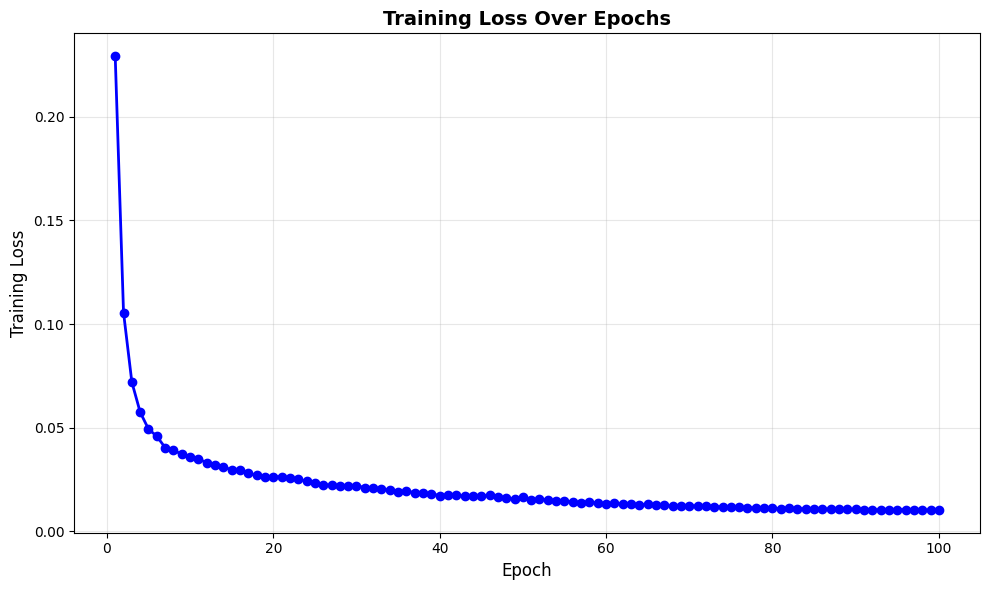

✅ Plot saved: /kaggle/working/POINTNET_20251222_133052/test_loss.png


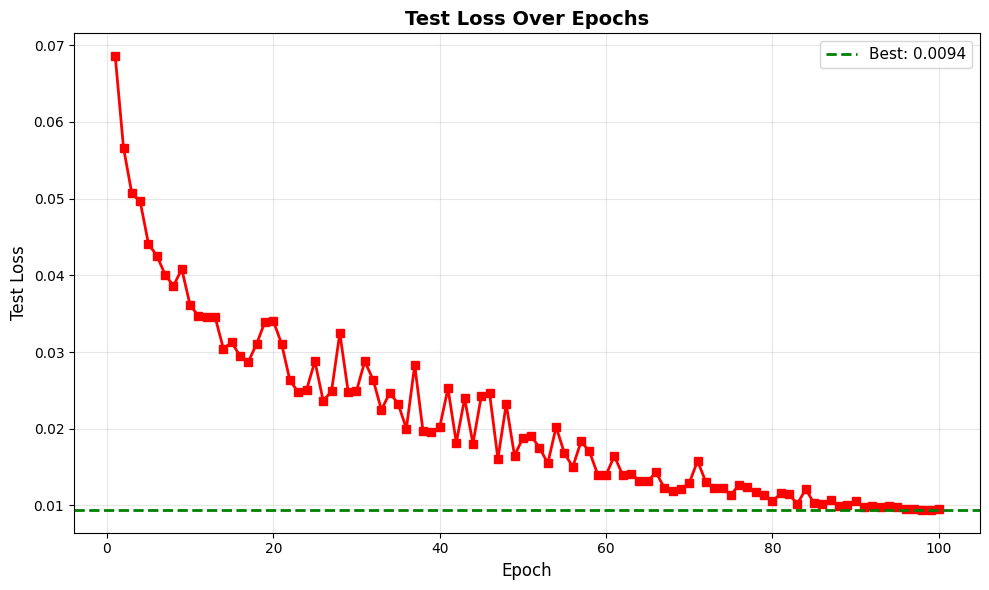


✅ All plots saved in '/kaggle/working/POINTNET_20251222_133052' directory!


In [44]:
import matplotlib.pyplot as plt

# Create plots directory
# plots_dir = "plots"
plots_dir = checkpoint_dir
os.makedirs(plots_dir, exist_ok=True)

# Plot 1: Training vs Test Loss
plt.figure(figsize=(10, 6))
epochs_range = range(1, len(test_losses)+1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(range(1, len(test_losses)+1), test_losses, 'r-s', label='Test Loss', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Test Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
loss_plot_path = os.path.join(plots_dir, "loss_comparison.png")
plt.savefig(loss_plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {loss_plot_path}")
plt.show()

# Plot 2: Only Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
train_loss_path = os.path.join(plots_dir, "training_loss.png")
plt.savefig(train_loss_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {train_loss_path}")
plt.show()

# Plot 3: Only Test Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_losses)+1), test_losses, 'r-s', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.title('Test Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=best_test_loss, color='g', linestyle='--', label=f'Best: {best_test_loss:.4f}', linewidth=2)
plt.legend(fontsize=11)
plt.tight_layout()
test_loss_path = os.path.join(plots_dir, "test_loss.png")
plt.savefig(test_loss_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {test_loss_path}")
plt.show()

print(f"\n✅ All plots saved in '{plots_dir}' directory!")

In [60]:
# Save losses
import pickle


losses_dict = {
    'train_losses': train_losses,
    'test_losses': test_losses
}

losses_path = os.path.join(checkpoint_dir, "losses.pkl")
with open(losses_path, 'wb') as f:
    pickle.dump(losses_dict, f)


# Visualize samples

In [53]:
sample.keys()

dict_keys(['points', 'centroid', 'rotation', 't_residual', 'gt_translation', 'object_id', 'class_idx', 'img_id', 'cam_K'])

📂 Caricamento checkpoint da: /kaggle/working/POINTNET_20251222_133052/best_model.pth
✅ Modello caricato dall'epoca 99 con loss: 0.0094

📷 Visualizing Sample 1808:
   Object ID: 10
   Image ID: 1141

📊 Ground Truth vs Prediction:
   GT Rotation:   [ 0.08351018 -0.05179561  0.832903   -0.5446244 ]
   Pred Rotation: [-0.06109198  0.07548686 -0.8292273   0.5504104 ]
   GT Trans (m):   [-0.00937163 -0.11308958  0.7964886 ]
   Pred Trans (m): [-0.00789991 -0.11380736  0.7956032 ]
   Translation Error: 0.19 cm


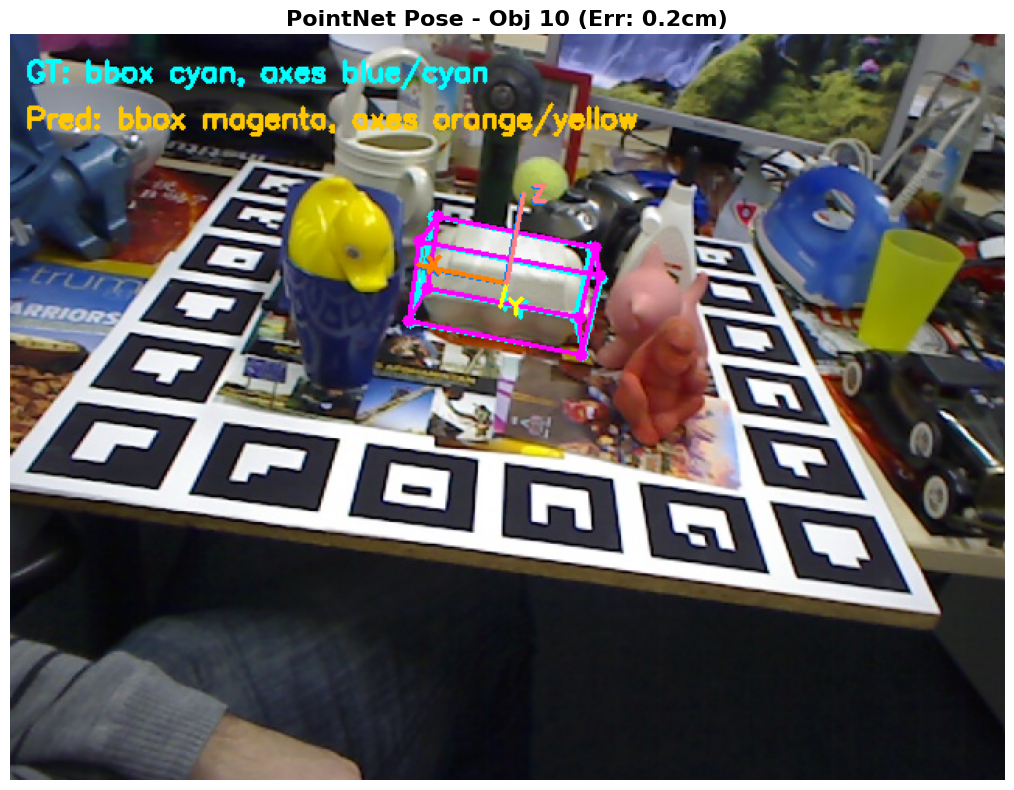


✅ Visualizzazione completata!


In [54]:
import random
import cv2
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
from utils.projection_utils import setup_projection_utils, visualize_pose_comparison

# ==========================================
# 1. SETUP E CARICAMENTO MODELLO
# ==========================================

# Setup projection utils (assumiamo dataset_root sia definito)
setup_projection_utils(dataset_root)

# Load best model
best_checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
if not os.path.exists(best_checkpoint_path):
    raise FileNotFoundError(f"Checkpoint non trovato: {best_checkpoint_path}")

print(f"📂 Caricamento checkpoint da: {best_checkpoint_path}")
checkpoint = torch.load(best_checkpoint_path, map_location=device)

state_dict = checkpoint['model_state_dict']

# Rimuovi il prefisso 'module.' se il modello era in DataParallel
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    # name = k[7:] if k.startswith('module.') else k 
    name = "module." + k
    new_state_dict[name] = v

# Inizializza il modello (Assumiamo PointNetPoseModel sia importata)
# model = PointNetPoseModel(num_points=1024).to(device) # Scommenta se devi instanziare
model.load_state_dict(new_state_dict)
model.eval()

print(f"✅ Modello caricato dall'epoca {checkpoint.get('epoch', '?')} con loss: {checkpoint.get('best_val_loss', '?'):.4f}")

# ==========================================
# 2. SELEZIONE E PREPARAZIONE SAMPLE
# ==========================================

# Seleziona un indice casuale dal test dataset
random_idx = random.randint(0, len(test_dataset) - 1)
sample = test_dataset[random_idx]

print(f"\n📷 Visualizing Sample {random_idx}:")
print(f"   Object ID: {sample['object_id']}")
# Gestione robusta nel caso 'img_id' manchi (vecchi dataset)
img_id_display = sample.get('img_id', 'N/A')
print(f"   Image ID: {img_id_display}")

# Recuperiamo l'immagine RGB originale per disegnare sopra
# Nel dataset PointNet non carichiamo l'RGB nel __getitem__, quindi dobbiamo farlo a mano qui
# Costruiamo il path usando le info nel sample o nel config
if 'img_path' in sample:
    img_path = sample['img_path']
else:
    # Fallback: ricostruiamo il path se non è nel sample
    # (Assumendo struttura LineMod standard)
    obj_id = sample['object_id']
    img_id = sample['img_id']
    img_path = os.path.join(dataset_root, 'data', f"{obj_id:02d}", 'rgb', f"{img_id:04d}.png")

image_bgr = cv2.imread(str(img_path))
if image_bgr is None:
    raise FileNotFoundError(f"Impossibile caricare immagine da: {img_path}")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# ==========================================
# 3. INFERENZA POINTNET
# ==========================================

# Prepara i tensori (Aggiungi dimensione batch)
points = sample['points'].unsqueeze(0).to(device)       # (1, 3, N)
centroid = sample['centroid'].unsqueeze(0).to(device)   # (1, 3)

with torch.no_grad():
    # Il modello restituisce rotazione E residuo traslazione
    pred_q, pred_t_res = model(points)
    
    # Ricostruzione Traslazione Assoluta
    # T_abs = Centroid + Residual
    pred_trans_abs = centroid + pred_t_res

# Converti in numpy per visualizzazione
pred_rotation = pred_q[0].cpu().numpy()
pred_translation = pred_trans_abs[0].cpu().numpy()

# Ground Truth
gt_rotation = sample['rotation'].numpy()
gt_translation = sample['gt_translation'].numpy() # O sample['translation']
cam_K = sample['cam_K'].numpy()

print(f"\n📊 Ground Truth vs Prediction:")
print(f"   GT Rotation:   {gt_rotation}")
print(f"   Pred Rotation: {pred_rotation}")
print(f"   GT Trans (m):   {gt_translation}")
print(f"   Pred Trans (m): {pred_translation}")

# Calcola errore distanza (solo per curiosità)
dist_error = np.linalg.norm(gt_translation - pred_translation)
print(f"   Translation Error: {dist_error*100:.2f} cm")

# ==========================================
# 4. VISUALIZZAZIONE
# ==========================================

# Visualizza confronto pose
# Nota: La funzione visualize_pose_comparison si aspetta un'immagine RGB (numpy)
img_vis = visualize_pose_comparison(
    image_rgb,
    object_id=sample['object_id'],
    cam_K=cam_K,
    gt_rotation=gt_rotation,
    gt_translation=gt_translation,
    pred_rotation=pred_rotation,
    pred_translation=pred_translation  # <-- ORA USIAMO LA TRASLAZIONE PREDETTA!
)

# Plot con Matplotlib
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
# visualize_pose_comparison ritorna RGB se gli passi RGB, quindi ok
ax.imshow(img_vis)
ax.axis('off')
ax.set_title(f"PointNet Pose - Obj {sample['object_id']} (Err: {dist_error*100:.1f}cm)", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Visualizzazione completata!")

In [55]:
import torch
import os

# Definizione percorso
save_path = "pointnet_vanilla_best.pth"

# Gestione DataParallel (se stavi usando 2 GPU)
if isinstance(model, torch.nn.DataParallel):
    state_dict = model.module.state_dict()
else:
    state_dict = model.state_dict()

# Salvataggio
torch.save(state_dict, save_path)

print(f"✅ Modello salvato in: {os.path.abspath(save_path)}")
print("⚠️ ORA SCARICALO SUBITO! Se la sessione cade, il file sparisce.")

checkpoint = {
    'epoch': 30,  # O l'ultima epoca a cui sei arrivato
    'model_state_dict': state_dict, # Usa lo state_dict pulito calcolato sopra
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': 0.0368, # La tua best loss
}

torch.save(checkpoint, "pointnet_checkpoint_full.pth")
print("✅ Checkpoint completo salvato.")

✅ Modello salvato in: /kaggle/working/6D_pose/pointnet_vanilla_best.pth
⚠️ ORA SCARICALO SUBITO! Se la sessione cade, il file sparisce.
✅ Checkpoint completo salvato.


In [56]:
!pip install trimesh

In [58]:
import torch
import numpy as np
import os
import trimesh
import pandas as pd
from collections import defaultdict
from tqdm.auto import tqdm
from metrics.ADD_metric import compute_ADD_metric_quaternion, compute_ADDs_metric_quaternion
# Ensure you import the correct PointNet model class here
from src.pose_pointnet.model import PointNetPoseModel 

# ==========================================
# 1. LOAD DATA AND DIAMETERS
# ==========================================
def load_models_info(models_dir, obj_ids, num_points=1000):
    """
    Loads sampled points and calculates the DIAMETER of each object.
    (This function remains unchanged as it works on .ply files).
    """
    point_cache = {}
    diameters = {}
    
    unique_ids = list(set(obj_ids))
    print(f"⏳ Loading info for {len(unique_ids)} models...")
    
    for oid in tqdm(unique_ids, desc="Mesh Analysis"):
        filename = f"obj_{int(oid):02d}.ply"
        path = os.path.join(models_dir, filename)
        
        if os.path.exists(path):
            mesh = trimesh.load(path)
            # 1. Sample points for ADD metric calculation
            points, _ = trimesh.sample.sample_surface(mesh, num_points)
            point_cache[oid] = points / 1000.0  # Convert mm to Meters
            
            # 2. Diameter Calculation (Max distance in the mesh)
            extents = mesh.extents / 1000.0  # Meters
            diameter = np.linalg.norm(extents)
            diameters[oid] = diameter
        else:
            print(f"⚠️ Missing model file: {path}")
            
    return point_cache, diameters

# ==========================================
# 2. COMPREHENSIVE EVALUATION (POINTNET VERSION)
# ==========================================
def evaluate_comprehensive(model, dataloader, device, models_dir, output_csv="evaluation_results.csv"):
    """
    Evaluates the PointNet model using ADD and ADD-S metrics.
    """
    model.eval()
    
    # --- MAPPING ID TO NAMES (LineMOD Standard) ---
    id_to_name = {
        1: 'ape', 2: 'benchvise', 4: 'camera', 5: 'can', 6: 'cat',
        8: 'driller', 9: 'duck', 10: 'eggbox', 11: 'glue',
        12: 'holepuncher', 13: 'iron', 14: 'lamp', 15: 'phone'
    }

    # Define IDs to evaluate
    all_obj_ids = list(id_to_name.keys())
    
    # Load mesh data (Points and Diameters)
    points_dict, diameters_dict = load_models_info(models_dir, all_obj_ids)
    
    # Data Structures for logging
    errors_dict = defaultdict(list)
    accuracy_stats = defaultdict(lambda: {"correct": 0, "total": 0})

    # Objects requiring ADD-S (Symmetric objects)
    SYMMETRIC_OBJECTS = [10, 11]  # Eggbox, Glue
    
    print("\n🚀 Starting Comprehensive Benchmark (ADD Error + ADD-0.1d Accuracy)...")
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # --- UPDATED INPUTS FOR POINTNET ---
            # We load points and centroids, not images
            points = batch['points'].to(device)           # (B, 3, N)
            centroids = batch['centroid'].to(device)      # (B, 3)
            
            gt_quats = batch['rotation'].to(device)       # (B, 4)
            gt_trans = batch['gt_translation'].to(device) # (B, 3) - Absolute GT
            obj_ids = batch['object_id']
            
            # --- FORWARD PASS ---
            # Predict Rotation and Residual Translation
            pred_quats, pred_t_res = model(points)
            
            # --- RECONSTRUCT ABSOLUTE TRANSLATION ---
            # Abs_Trans = Centroid + Residual
            pred_trans_abs = centroids + pred_t_res
            
            batch_size = points.shape[0]
            for i in range(batch_size):
                curr_id = int(obj_ids[i])
                if curr_id not in points_dict: continue

                # Select Metric: ADD-S for symmetric, ADD for others
                metric = compute_ADDs_metric_quaternion if curr_id in SYMMETRIC_OBJECTS else compute_ADD_metric_quaternion
                
                # --- CALCULATE ERROR ---
                # We pass the PREDICTED translation (pred_trans_abs), not the GT one!
                # This evaluates the full 6D pose (Rot + Trans).
                add_error = metric(
                    model_points=points_dict[curr_id],
                    gt_quat=gt_quats[i].cpu().numpy(),
                    gt_translation=gt_trans[i].cpu().numpy(),
                    pred_quat=pred_quats[i].cpu().numpy(),
                    pred_translation=pred_trans_abs[i].cpu().numpy() 
                )
                
                # Store absolute error
                errors_dict[curr_id].append(add_error)
                
                # Calculate Accuracy (Threshold = 10% of diameter)
                threshold = diameters_dict[curr_id] * 0.1
                accuracy_stats[curr_id]["total"] += 1
                if add_error < threshold:
                    accuracy_stats[curr_id]["correct"] += 1

    # ==========================================
    # 3. PANDAS REPORT GENERATION
    # ==========================================
    results_data = []
    
    total_acc_correct = 0
    total_acc_count = 0
    total_errors = []

    sorted_ids = sorted(errors_dict.keys())
    
    for oid in sorted_ids:
        # Error stats
        mean_err_m = np.mean(errors_dict[oid])
        mean_err_cm = mean_err_m * 100.0
        total_errors.extend(errors_dict[oid])
        
        # Accuracy stats
        stats = accuracy_stats[oid]
        acc_perc = (stats["correct"] / stats["total"]) * 100.0 if stats["total"] > 0 else 0.0
        
        total_acc_correct += stats["correct"]
        total_acc_count += stats["total"]
        
        diam_cm = diameters_dict[oid] * 100.0
        
        # Get Class Name
        class_name = id_to_name.get(oid, "Unknown")

        # Append to list
        results_data.append({
            "Object ID": oid,
            "Class Name": class_name,
            "Diameter (cm)": round(diam_cm, 2),
            "Mean ADD Error (cm)": round(mean_err_cm, 2),
            "Accuracy (%)": round(acc_perc, 2),
            "Samples": stats['total']
        })

    # Create DataFrame
    df = pd.DataFrame(results_data)

    # Calculate Global Stats
    global_mean_error_cm = np.mean(total_errors) * 100.0 if total_errors else 0.0
    global_accuracy = (total_acc_correct / total_acc_count * 100.0) if total_acc_count > 0 else 0.0

    # Add Global Row
    global_row = pd.DataFrame([{
        "Object ID": "GLOBAL",
        "Class Name": "ALL", 
        "Diameter (cm)": "-",
        "Mean ADD Error (cm)": round(global_mean_error_cm, 2),
        "Accuracy (%)": round(global_accuracy, 2),
        "Samples": total_acc_count
    }])
    
    df = pd.concat([df, global_row], ignore_index=True)

    # Print and Save
    print("\n" + "="*80)
    print("FINAL EVALUATION REPORT (POINTNET)")
    print("="*80)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    
    print(df.to_string(index=False))
    print("="*80)
    
    df.to_csv(output_csv, index=False)
    print(f"✅ Results saved to {output_csv}")

In [59]:
from collections import OrderedDict
# --- USAGE ---

# 1. Define Paths
MODELS_ROOT = "/kaggle/input/line-mode/Linemod_preprocessed/models"
# in case of the samll dataset
# MODELS_ROOT = "/kaggle/input/linemode-preprocessed-small/Linemod_preprocessed_small/models"
checkpoint_path = checkpoint_dir + "/best_model.pth"

# 2. Load Checkpoint
print(f"📂 Loading checkpoint from: {checkpoint_path}")
data = torch.load(checkpoint_path, map_location=device)
state_dict = data['model_state_dict']

# 3. Clean State Dict (Remove 'module.' prefix from DataParallel)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] if k.startswith('module.') else k 
    new_state_dict[name] = v

# 4. Initialize and Load Model
test_model = PointNetPoseModel()
test_model.load_state_dict(new_state_dict)
test_model.to(device)

# 5. Run Evaluation
evaluate_comprehensive(
    test_model, 
    test_loader, 
    device, 
    MODELS_ROOT, 
    output_csv=checkpoint_dir + '/linemod_results.csv'
)

📂 Loading checkpoint from: /kaggle/working/POINTNET_20251222_133052/best_model.pth
⏳ Loading info for 13 models...


Mesh Analysis:   0%|          | 0/13 [00:00<?, ?it/s]


🚀 Starting Comprehensive Benchmark (ADD Error + ADD-0.1d Accuracy)...


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]


FINAL EVALUATION REPORT (POINTNET)
Object ID  Class Name Diameter (cm)  Mean ADD Error (cm)  Accuracy (%)  Samples
        1         ape         14.21                 0.63         95.56      248
        2   benchvise         33.09                 1.23         96.71      243
        4      camera         22.19                 0.82         96.27      241
        5         can         28.42                 1.04         96.25      240
        6         cat         18.59                 0.60         98.31      236
        8     driller         31.88                 1.32         96.22      238
        9        duck         15.57                 0.71         96.02      251
       10      eggbox          19.7                 0.51        100.00      251
       11        glue         19.31                 0.50         99.59      244
       12 holepuncher         17.38                 0.71         96.77      248
       13        iron         31.72                 7.56         46.32      231
    